<a href="https://colab.research.google.com/github/RH-Pronoy/BlackList/blob/main/Rice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pandas pillow

In [3]:
!pip install pandas
!pip install opencv-python

In [1]:
!pip install tensorflow==2.12.0
!pip install keras

In [2]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Import RandomFlip and RandomRotation from the preprocessing module
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU

In [3]:
IMG_SIZE = (299, 299) # resolution
directory = "/content/drive/MyDrive/Bangladeshi Crop Diseases detection dataset/Dataset/Rice Leaf Diseases Dataset From Bangladesh"
BATCH_SIZE = 128
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)

Found 2791 files belonging to 4 classes.
Using 2512 files for training.
Found 2791 files belonging to 4 classes.
Using 279 files for validation.


In [4]:
class_names = train_dataset.class_names
class_names

['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Hispa', 'Rice___Leaf_Blast']

<ipython-input-5-cc51f24ec1db>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Hispa', 'Rice___Leaf_Blast'], y=Data_imbalance, palette="rocket")


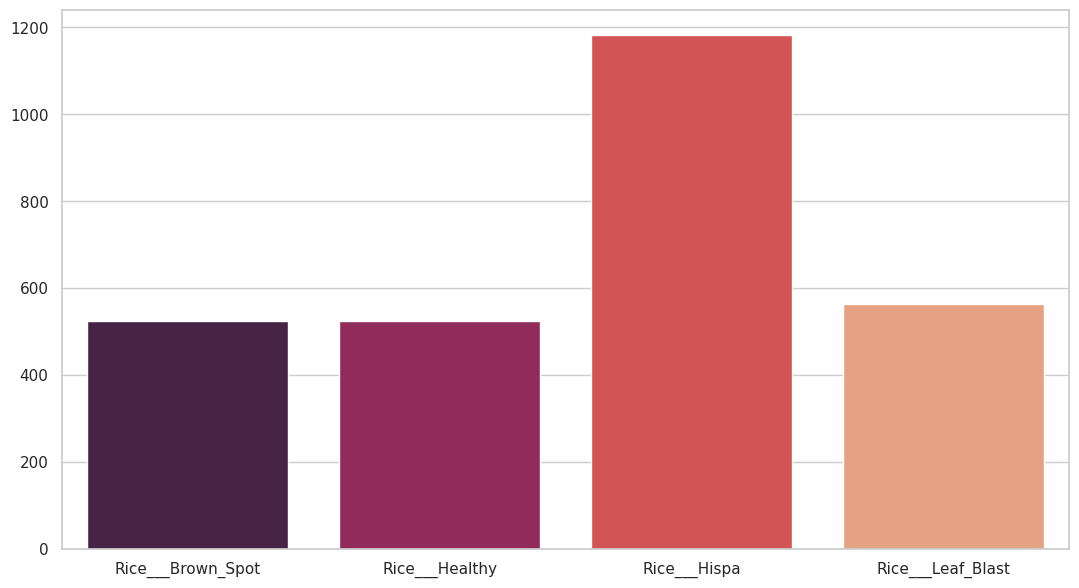

In [5]:
sns.set_theme(style="whitegrid")
Data_imbalance = []
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
plt.figure(figsize=(13,7))
sns.barplot(x=['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Hispa', 'Rice___Leaf_Blast'], y=Data_imbalance, palette="rocket")
plt.show()

In [6]:
total = 0
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i]

weight_for_0 = (1 / Data_imbalance[0]) * (total / 4.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 4.0)
weight_for_2 = (1 / Data_imbalance[2]) * (total / 4.0)
weight_for_3 = (1 / Data_imbalance[3]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))


Weight for class 0: 1.33
Weight for class 1: 1.33
Weight for class 2: 0.59
Weight for class 3: 1.24


In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

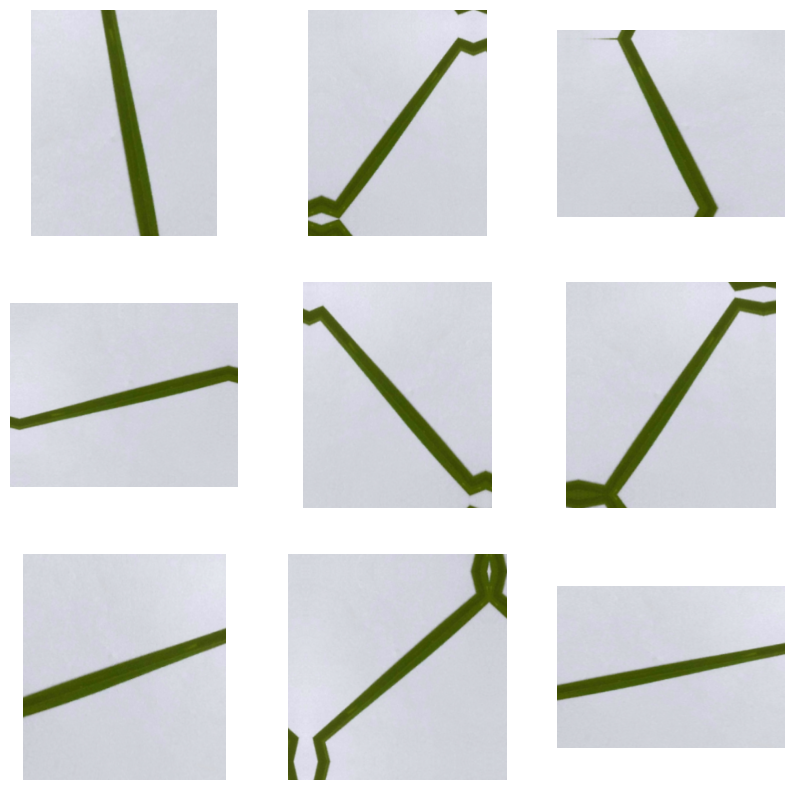

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

**Rice___Brown_Spott**

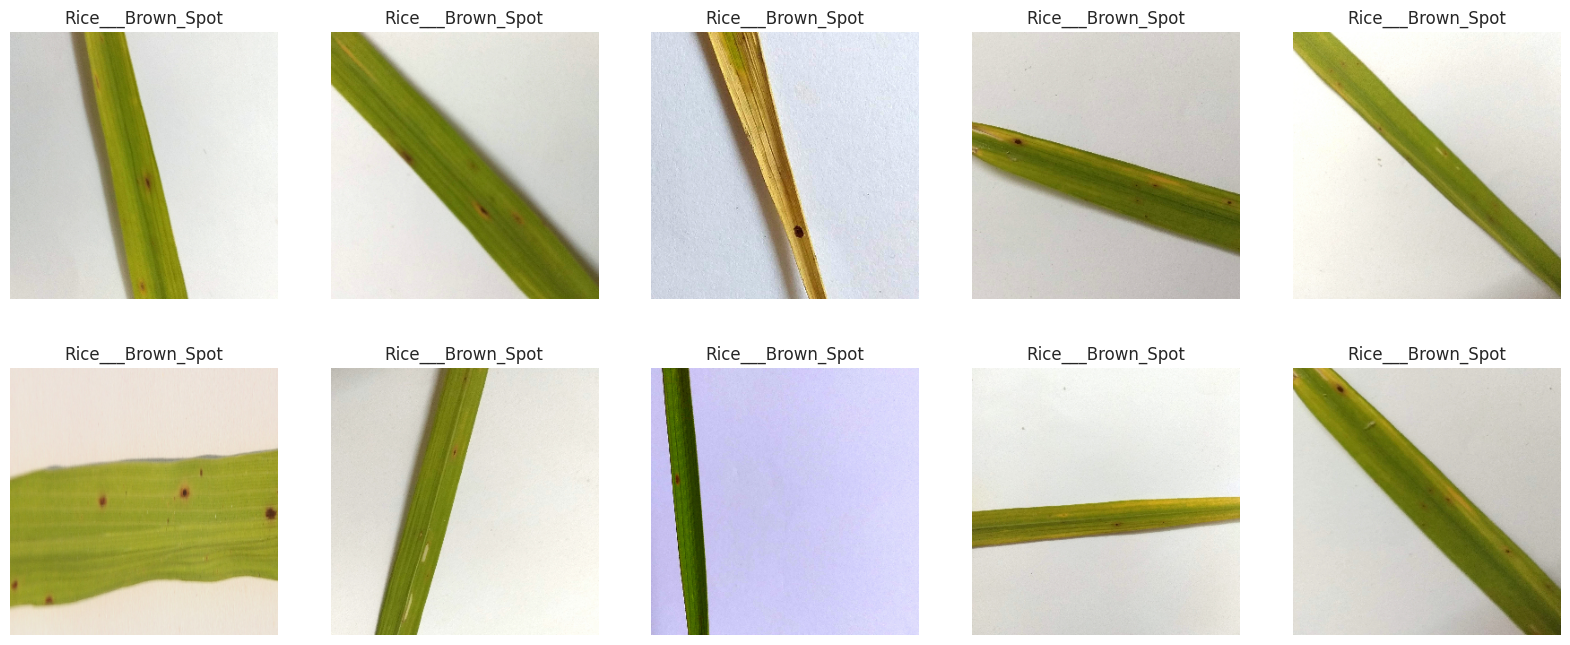

In [9]:
plt.figure(figsize=(20,8))
Rice___Brown_Spot = []
Rice___Hispa= []
Rice___Leaf_Blast =[]


for images , labels in train_dataset.take(1):
    for i in range(100):
        if class_names[labels[i]] == "Rice___Brown_Spot":
            Rice___Brown_Spot.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Rice___Hispa":
            Rice___Hispa.append(images[i].numpy().astype("uint8"))
        if  class_names[labels[i]] == "Rice___Leaf_Blast":
            Rice___Leaf_Blast.append(images[i].numpy().astype("uint8"))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Rice___Brown_Spot[i])
    plt.axis("off")
    plt.title("Rice___Brown_Spot")

**Rice___Hispa**

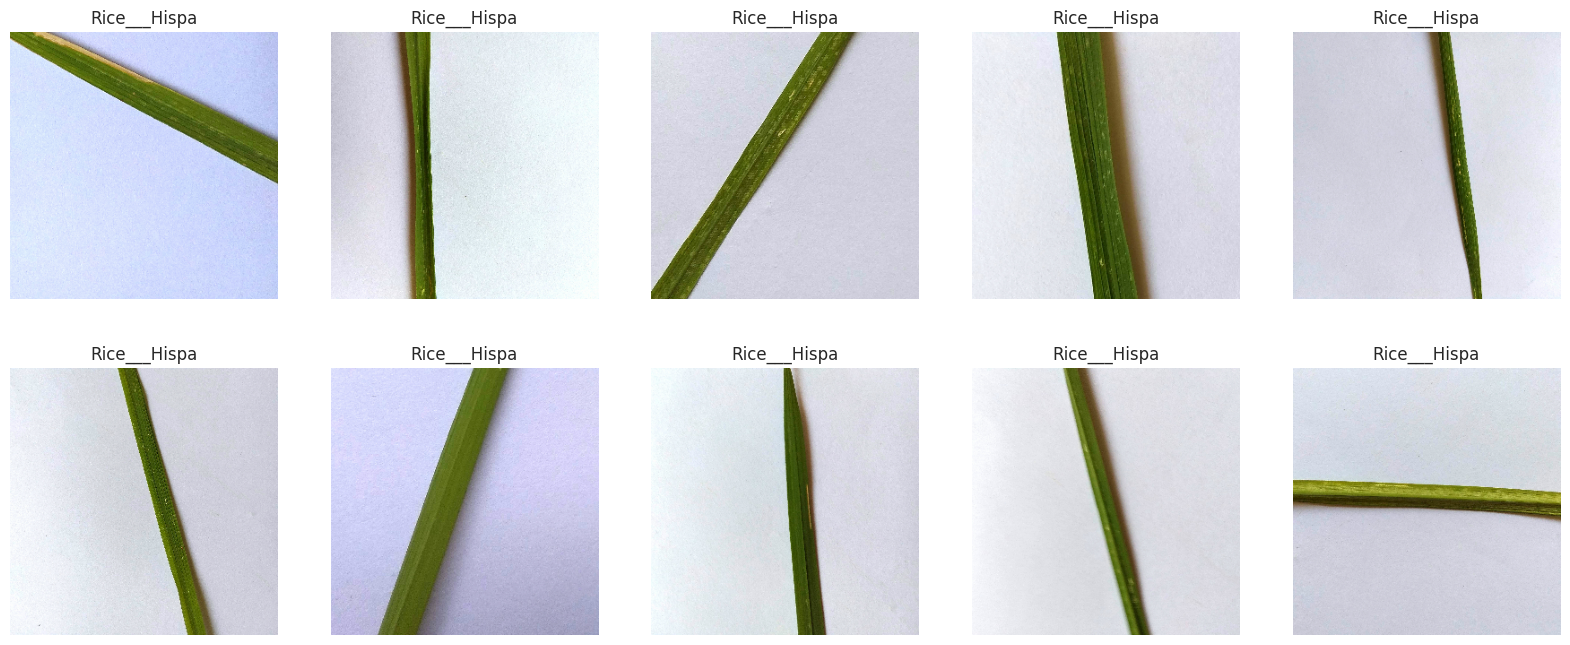

In [10]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Rice___Hispa[i])
    plt.axis("off")
    plt.title("Rice___Hispa")

**Rice___Leaf_Blast**

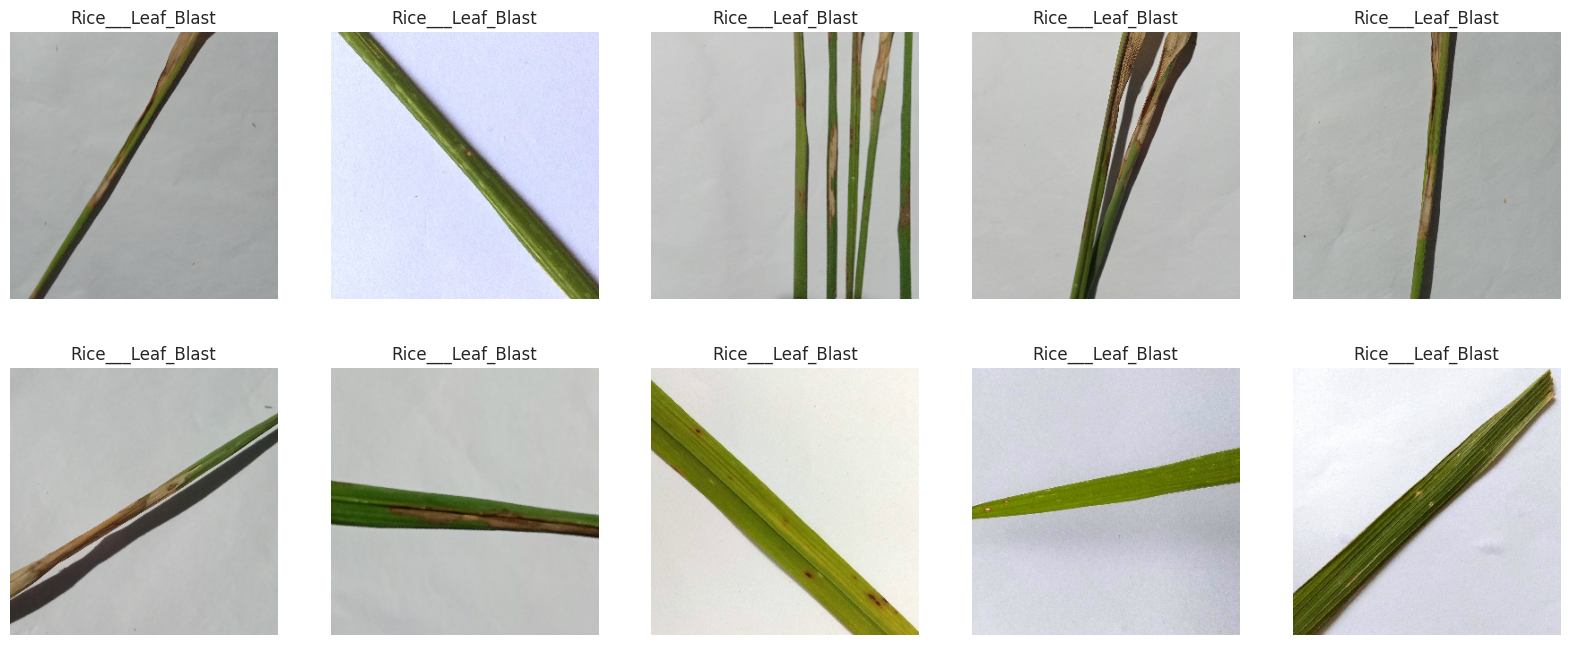

In [11]:
plt.figure(figsize=(20,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Rice___Leaf_Blast[i])
    plt.axis("off")
    plt.title("Rice___Leaf_Blast")


**Powdery_Mildew**

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

**Modeling**

In [13]:
IMG_SHAPE = IMG_SIZE +(3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [14]:
type(base_model)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [15]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)

Numbers of Layers = 311
activation_93
mixed10


In [16]:
# iterate over first batch (32 image) in trainset
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(128, 8, 8, 2048)


**Inception V3 (2015)**

In [17]:
def plant_leaf_model( image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)

    resnet_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    resnet_model.trainable = True
    for layer in resnet_model.layers[0 : 291]:
        layer.trainable = False

    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = resnet_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(4 ,activation = "softmax")
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model

In [18]:
Plant_Leaf_Model = plant_leaf_model(IMG_SIZE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [19]:
base_learning_rate = 0.001
Plant_Leaf_Model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

In [20]:
history = Plant_Leaf_Model.fit(train_dataset , verbose=2 , epochs=10 ,class_weight=class_weight,
                               validation_data=validation_dataset , use_multiprocessing= True)

Epoch 1/10
20/20 - 992s - loss: 1.6947 - accuracy: 0.5358 - val_loss: 0.9508 - val_accuracy: 0.6165 - 992s/epoch - 50s/step
Epoch 2/10
20/20 - 922s - loss: 0.7741 - accuracy: 0.6771 - val_loss: 0.7599 - val_accuracy: 0.6846 - 922s/epoch - 46s/step
Epoch 3/10
20/20 - 921s - loss: 0.6618 - accuracy: 0.7237 - val_loss: 0.7241 - val_accuracy: 0.7168 - 921s/epoch - 46s/step
Epoch 4/10
20/20 - 915s - loss: 0.5823 - accuracy: 0.7592 - val_loss: 0.8425 - val_accuracy: 0.6559 - 915s/epoch - 46s/step
Epoch 5/10
20/20 - 921s - loss: 0.5287 - accuracy: 0.7775 - val_loss: 0.6234 - val_accuracy: 0.7455 - 921s/epoch - 46s/step
Epoch 6/10
20/20 - 964s - loss: 0.4628 - accuracy: 0.8089 - val_loss: 0.6092 - val_accuracy: 0.7419 - 964s/epoch - 48s/step
Epoch 7/10
20/20 - 916s - loss: 0.3838 - accuracy: 0.8392 - val_loss: 0.6068 - val_accuracy: 0.7419 - 916s/epoch - 46s/step
Epoch 8/10
20/20 - 915s - loss: 0.3647 - accuracy: 0.8483 - val_loss: 0.7140 - val_accuracy: 0.7061 - 915s/epoch - 46s/step
Epoch 9/

In [21]:
Plant_Leaf_Model.evaluate(validation_dataset , verbose = 1)

3/3 [==============================] - 88s 20s/step - loss: 0.7156 - accuracy: 0.6846


[0.7155981659889221, 0.684587836265564]

1/1 [==============================] - 0s 253ms/step


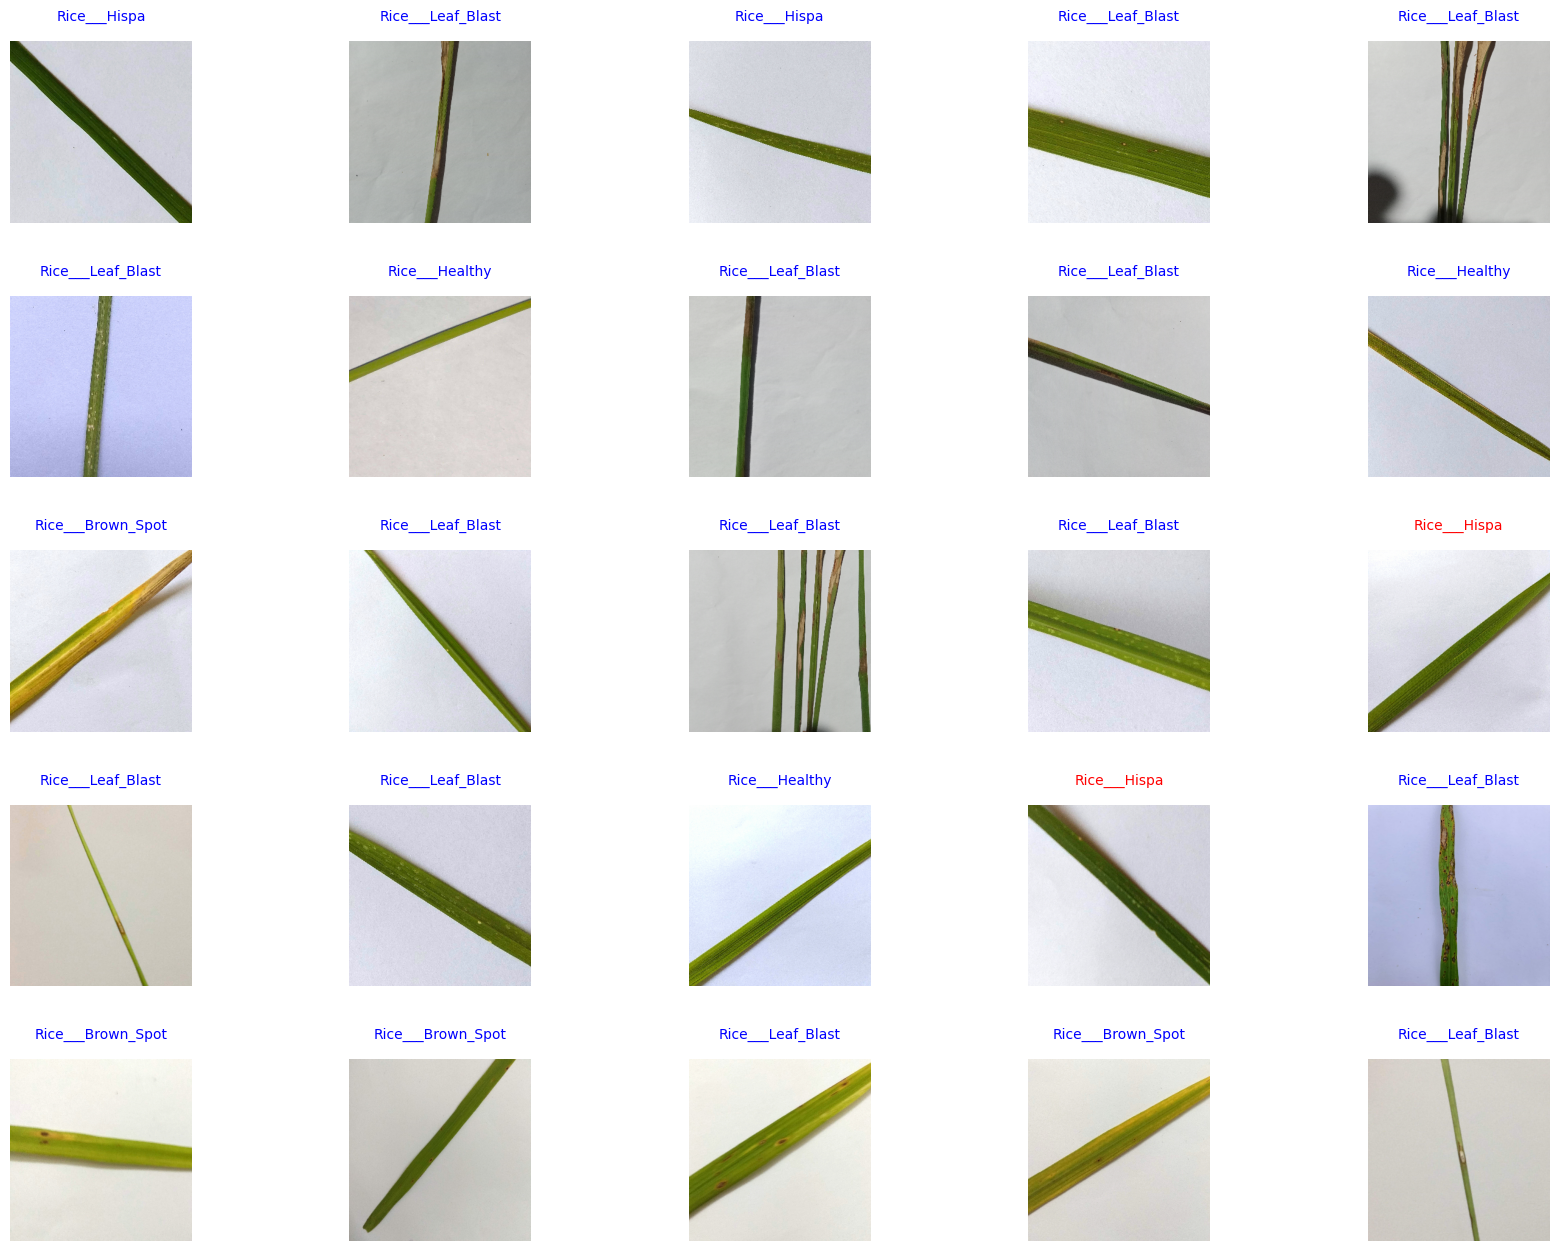

In [22]:
plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = Plant_Leaf_Model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,
                            top=0.9, wspace=0.4,hspace=0.4)

**Plotting Accuracy**

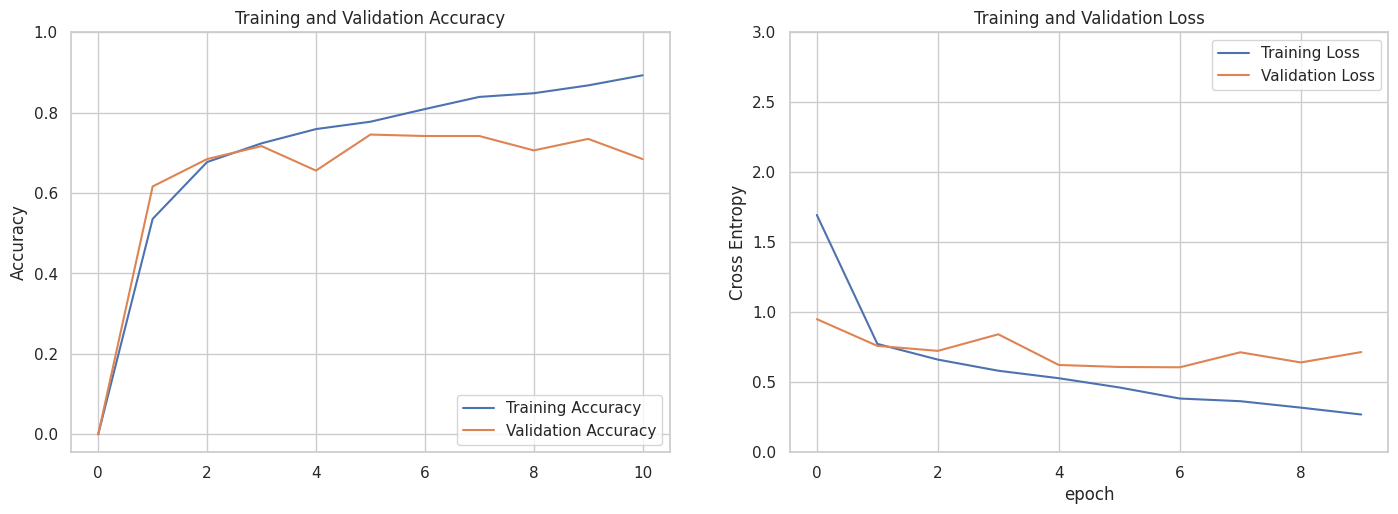

In [23]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()